In [1]:
from google.colab import drive
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 18 03:33:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.2 MB/s 


In [5]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random



#Sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#matplot
import matplotlib.pyplot as plt


#embedding
from gensim.models import Word2Vec

# tqdm
from tqdm.notebook import tqdm

#tensorflow
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, Flatten,Dense
from tensorflow import keras
import tensorflow_addons as tfa
from keras import backend as K

#os
import os



# Data-preprocessing

In [80]:
train_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/train.json"
test_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/test.json"

with open(train_file_path, 'r') as f:
    data = json.load(f)
df_train = pd.DataFrame(data)

with open(test_file_path, 'r') as f:
    data = json.load(f)
df_test = pd.DataFrame(data)

In [93]:
# author feature is used to retreive the corresponding labels and the coauthor feature is used for further training

# Retrieve the non-prolific author and prolific author index
non_prolific_author_index = []
prolific_author_index = []
for i,j in enumerate(df_train['authors']):
  sum = 0
  for k in j:
    if k < 100 and k >= 0:
      sum += 1
  if sum == 0:
    non_prolific_author_index.append(i)
  else:
    prolific_author_index.append(i)

df_non_prolifc_authors = df_train.drop(prolific_author_index)
df_prolific_authors = df_train.drop(non_prolific_author_index)


# create a new column for coauthor of prolific author dataframe
prolific_author_label = []
non_prolific_author_label = []
for i in df_prolific_authors['authors']:
  prolific_author_label_each_instance = []
  non_prolific_author_label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      prolific_author_label_each_instance.append(j)
    else:
      non_prolific_author_label_each_instance.append(j)
  prolific_author_label.append(prolific_author_label_each_instance)
  non_prolific_author_label.append(non_prolific_author_label_each_instance)

#Creat a new column for futher training features

df_prolific_authors['coauthors'] = non_prolific_author_label

# get the corresponding percentage of non prolific author
# selected_col_nums = 18333
# non_prolific_author_rows =[]

# for i in range(selected_col_nums):
#   non_prolific_author_rows.append(random.randint(0,18334))

# df_selected_non_prolific_authors = df_non_prolifc_authors.iloc[non_prolific_author_rows]

# df_selected_non_prolific_authors['coauthors'] = df_selected_non_prolific_authors.loc[:,'authors']
df_non_prolifc_authors['coauthors'] = df_non_prolifc_authors.loc[:,'authors']

N = 10
repeated_prolific_author = pd.concat([df_prolific_authors] * N, ignore_index=True)

df_selected_data = pd.concat([df_non_prolifc_authors, repeated_prolific_author], axis = 0)

In [94]:

df_selected_data


,authors,year,abstract,venue,title,coauthors
2,"[19166, 17763]",17,"[40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...",,"[2085, 1719, 1846, 1745, 2243, 1553, 1606, 159...","[19166, 17763]"
5,"[5396, 16841, 17598, 20375, 11436]",18,"[40, 1542, 1691, 3133, 33, 1923, 1650, 1642, 1...",4,"[46, 1617, 1667, 3979, 2073, 37, 53, 2080, 154...","[5396, 16841, 17598, 20375, 11436]"
6,"[4874, 20811]",14,"[37, 2067, 1681, 1866, 51, 1612, 43, 1545, 181...",0,"[34, 3646, 2073, 2035, 2346, 1886, 1543, 57, 1...","[4874, 20811]"
7,"[1398, 11095]",10,"[1664, 1575, 3781, 4692, 10, 1706, 1860, 2000,...",26,"[1615, 1966, 11, 3495, 1656, 4345, 24, 2353, 1...","[1398, 11095]"
8,"[12449, 20348]",18,"[46, 4822, 1692, 1553, 3591, 4914, 46, 2421, 6...",9,"[3591, 4914, 46, 2421, 1608, 37, 1740, 1825, 1...","[12449, 20348]"
...,...,...,...,...,...,...
74595,"[19974, 68, 8903]",1,"[40, 1542, 1691, 2449, 1535, 2855, 1549, 1755,...",23,"[1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359...","[19974, 8903]"
74596,"[6353, 67, 3037, 15856, 13521]",10,"[40, 1542, 1691, 2907, 1540, 1535, 2121, 2431,...",10,"[53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3...","[6353, 3037, 15856, 13521]"
74597,"[7686, 3810, 87, 7451]",16,"[2144, 1661, 2151, 1966, 3776, 4864, 1546, 219...",31,"[1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1...","[7686, 3810, 7451]"
74598,"[14864, 92]",16,"[37, 1662, 33, 1814, 2036, 1692, 1553, 2333, 2...",0,"[46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152...",[14864]


In [95]:
# fill the empty string value of the title with -1 and plus one to avoid messing with the padding value


venue_list = []
for i in df_selected_data['venue']:
  if i == '':
    venue_list.append(-1)
  else:
    venue_list.append(i + 1)
  
df_selected_data = df_selected_data.drop(['venue'],axis = 1)
df_selected_data['venue'] =venue_list

print('number of void string of the venue',len(df_selected_data[df_selected_data['venue'] == -1].index.tolist()))

number of void string of the venue 4089


In [96]:
#One-hot encoding the labels

total_label = []
for i in df_selected_data['authors']:
  label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      label_each_instance.append(j)
  if len(label_each_instance) == 0:
    label_each_instance.append(100)
  total_label.append(label_each_instance)


multilable_binarizer = MultiLabelBinarizer()
ohe_prolific_labels = multilable_binarizer.fit_transform(total_label).astype('float')


In [97]:
ohe_prolific_labels.shape

(92933, 101)

dict_keys([100, 36, 42, 45, 97, 2, 44, 76, 78, 49, 32, 58, 95, 0, 14, 4, 9, 30, 47, 15, 28, 94, 83, 24, 16, 10, 31, 33, 50, 65, 88, 74, 39, 96, 26, 34, 37, 75, 82, 13, 71, 7, 19, 99, 52, 21, 69, 5, 70, 20, 1, 57, 53, 81, 92, 29, 85, 12, 59, 38, 6, 23, 98, 25, 18, 77, 87, 79, 11, 61, 46, 84, 17, 41, 43, 54, 62, 3, 89, 90, 40, 73, 8, 67, 55, 64, 80, 27, 56, 51, 35, 66, 72, 22, 68, 60, 63, 91, 86, 48, 93])
[2500  113   54  106   99   75   74   65  141   80  126   72   72  125
   69   75   52   76  166  143   97   66  114   90  122  163  108   74
   93  116   48  118   97   62  192   60   85  110   77   87   62   86
  135   58   60  101   92   73   64   55   53  114  183  107  100   71
   94  152   99  108  117   68   94  155   56  119  100  105  124   87
   87  143   79  140   64   42   67   55   59   71   81   77   66  113
   63   75   49  115   76   53   68   84   81   76   83   38   66   54
   48   72   39]
[0.21856968 0.00987935 0.00472111 0.00926735 0.00865536 0.00655709
 0.00646966 

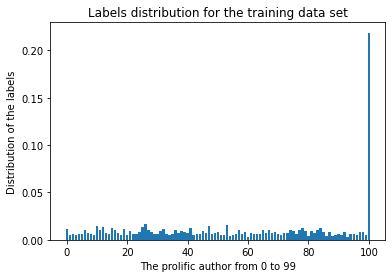

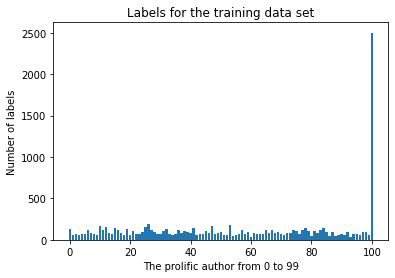

In [56]:
label_distribution = {}
for i in ohe_prolific_labels:
  for j in range(101):
    if i[j] == 1:
      label_distribution[j] = label_distribution.get(j, 0) + 1


label_distribution
keys = label_distribution.keys()
vals = label_distribution.values()

label_distribution_prob = np.array(list(vals))/np.sum(np.array(list(vals)))
total_number_instances = np.sum(np.array(list(vals)))
label_distribution = np.array(list(vals))
print(keys)
print(label_distribution)
print(label_distribution_prob)

plt.bar(keys, label_distribution_prob, label="Real distribution of labels")
plt.title('Labels distribution for the training data set')
plt.xlabel('The prolific author from 0 to 99')
plt.ylabel('Distribution of the labels')
plt.show()

plt.bar(keys, label_distribution, label="Number of labels")
plt.title('Labels for the training data set')
plt.xlabel('The prolific author from 0 to 99')
plt.ylabel('Number of labels')
plt.show()


# Word2Vec

In [ ]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list


def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    total_list.append(per_instance)
  return total_list

# word to vec title model
string_title = convert_to_string(df_train['title'])
# Word2Vec
model_title = Word2Vec(string_title, min_count=1)
print(model_title)











Word2Vec(vocab=3444, size=100, alpha=0.025)


In [ ]:
type(df_train['title'][0])

list

In [ ]:
# word to vec coauthor model
string_coauthor = convert_to_string(df_train['authors'])

model_coauthor = Word2Vec(string_coauthor, min_count=1)
print(model_coauthor)

Word2Vec(vocab=20433, size=100, alpha=0.025)


In [ ]:
# word to vec abstract model
string_abstract = convert_to_string(df_train['abstract'])
# Word2Vec

model_abstract = Word2Vec(string_abstract, min_count=1,workers=4)
print(model_abstract)

Word2Vec(vocab=4845, size=100, alpha=0.025)


In [ ]:
string_abstract = convert_to_string(df_train['abstract'])

In [ ]:
print(model_abstract.similarity('1', '2'))

0.34725717


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
model_abstract.wv['1']

array([ 0.9325655 ,  1.1048778 , -0.15912808,  0.16575037,  0.59627134,
        0.39444566,  0.15305175, -0.49195415, -1.828572  , -0.06493202,
        0.07254826,  0.4224136 , -0.80887705, -1.4045439 ,  0.6578873 ,
        0.24273317,  0.24299057, -1.0093166 ,  0.08629867, -0.47859758,
       -0.01759059, -0.5093286 ,  0.41642383,  0.18799575, -0.13638149,
       -0.0431513 , -0.25417936, -0.2425057 , -0.08023779, -0.7270764 ,
       -1.3128622 ,  0.6195528 ,  0.36813024,  0.32848597,  0.13390033,
        0.38901263,  0.75449455,  0.25247437, -0.15829611,  1.4501023 ,
       -0.5762748 , -0.3457888 ,  0.75169176, -0.02400872,  0.23553978,
       -0.29057682,  0.1539837 , -0.02277344,  0.10162782, -0.71708614,
       -0.22289154, -0.8955829 , -0.42532682, -0.06255367,  1.0788614 ,
        0.19098991,  0.16953976, -0.94783723, -0.6114193 , -0.18021299,
       -0.00433659, -0.294838  ,  0.7437635 ,  0.50315166, -0.5933357 ,
        0.8645253 , -0.5065468 , -0.09049308, -0.13299192,  0.79

In [ ]:
from gensim.models.keyedvectors import KeyedVectors








#Tensorflow


In [98]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list

# Handle the situation where the coauthor is zero
def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    if len(per_instance) == 0:
      per_instance.append(21246)
    total_list.append(per_instance)
  return total_list

num_coauthor = convert_to_num(df_selected_data['coauthors'])
num_abstract = convert_to_num(df_selected_data['abstract'])
num_title = convert_to_num(df_selected_data['title'])

max_length_coauthor = max([len(i)for i in num_coauthor])
max_length_abstract = max([len(i)for i in num_abstract])
max_length_title = max([len(i)for i in num_title])
print('max_length_coauthor' ,max_length_coauthor)
print('max_length_abstract ',max_length_abstract)
print('max_length_title ', max_length_title)
print(min([len(i)for i in num_coauthor]))

max_length_coauthor 100
max_length_abstract  2804
max_length_title  127
1


In [99]:
padded_coauthor = pad_sequences(num_coauthor,truncating = 'post',maxlen = 100,padding ='post')
padded_title = pad_sequences(num_title,truncating = 'post',maxlen = 20,padding ='post')
padded_abastract = pad_sequences(num_abstract,truncating = 'post',maxlen = 128,padding ='post')
# padded_venue = pad_sequences(df_selected_data['venue'].tolist(),truncating = 'post',maxlen = 64,padding ='post')



df_real_train = pd.DataFrame({'coauthor':padded_coauthor.tolist(),'title':padded_title.tolist(),'abstract':padded_abastract.tolist(),'venue':df_selected_data['venue'].tolist()})

In [100]:
X_train,X_test,y_train,y_test = train_test_split(df_real_train,ohe_prolific_labels,test_size=0.00001,random_state=90051,shuffle = True)
X_train = [tf.convert_to_tensor(X_train['abstract'].to_list()),tf.convert_to_tensor(X_train['coauthor'].to_list()),tf.convert_to_tensor(X_train['title'].to_list()),tf.convert_to_tensor(X_train['venue'].to_list())]
X_test = [tf.convert_to_tensor(X_test['abstract'].to_list()),tf.convert_to_tensor(X_test['coauthor'].to_list()),tf.convert_to_tensor(X_test['title'].to_list()),tf.convert_to_tensor(X_test['venue'].to_list())]

In [101]:
embedding_dimension = 128
vocabulary_size_title_abstract = 5000
vocabulary_size_coauthor = 21247
vocabulary_size_venue = 466

max_length_abstract = 128
max_length_title = 20
max_length_coauthor = 100
max_length_venue = 1

checkpoint_path = 'model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                              save_best_only=True,
                                              monitor = 'val_loss',
                                              mode='min')


inputs_abstract = keras.Input((max_length_abstract))
inputs_coauthor = keras.Input((max_length_coauthor))
inputs_title = keras.Input((max_length_title))
inputs_venue = keras.Input((max_length_venue))

abstract_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_abstract, embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_abstract)
average_pool1 = layers.GlobalAveragePooling1D()(abstract_embed_layer)

coauthor_embed_layer = layers.Embedding(input_dim = vocabulary_size_coauthor,mask_zero=True, output_dim = embedding_dimension,input_length = max_length_coauthor,embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_coauthor)
average_pool2 = layers.GlobalAveragePooling1D()(coauthor_embed_layer)

title_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_title, embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_title)
average_pool3 = layers.GlobalAveragePooling1D()(title_embed_layer)

venue_embed_layer = layers.Embedding(input_dim = vocabulary_size_venue, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_venue,embeddings_regularizer= tf.keras.regularizers.L2(0))(inputs_venue)
average_pool4 = layers.GlobalAveragePooling1D()(venue_embed_layer)

concatenated_layer = layers.Concatenate(axis = 1)([average_pool1, average_pool2,average_pool3,average_pool4])
# average_pool = layers.GlobalAveragePooling1D()(concatenated_layer)
x0 = layers.Dense(512, activation="tanh")(concatenated_layer)
x = layers.Dropout(0.3)(x0)
x1 = layers.Dense(256, activation="tanh")(x)
# x2 = layers.Dropout(0.1)(x1)
# x3 = layers.Dense(256, activation="relu") (x2)
x4 = layers.Dropout(0.3) (x1)
x5 = layers.Dense(101,activation="sigmoid") (x4)
model = keras.Model([inputs_abstract,inputs_coauthor,inputs_title,inputs_venue],x5)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [102]:
class_weight = {}
for i in range(101):
  class_weight[i] = 1
class_weight[100] = 0.3



# metrics = tfa.metrics.F1Score(num_classes=100,threshold = 0.6, average='macro')
# metrics = tf.keras.metrics.CategoricalAccuracy()
METRICS = [
      # keras.metrics.Precision(name='precision'),
      # keras.metrics.Recall(name='recall'),
      tfa.metrics.F1Score(num_classes=100,threshold = 0.5, average='macro')
]
starter_learning_rate = 0.001
end_learning_rate = 0.0001
decay_steps = 100
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

# loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2,from_logits=False)
# loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.BinaryCrossentropy()



optimizer = optimizers.Adam(learning_rate =starter_learning_rate)
model.compile(loss= loss, optimizer= optimizer)

history = model.fit(X_train,y_train, epochs = 150, batch_size= 128)


# history = model.fit(X_train,y_train, epochs = 20, batch_size= 32,callbacks = [callback], validation_data = (X_test,y_test),shuffle = True)

Epoch 1/150
727/727 [==============================] - 5s 5ms/step - loss: 0.0642
Epoch 2/150
727/727 [==============================] - 4s 5ms/step - loss: 0.0163
Epoch 3/150
727/727 [==============================] - 4s 5ms/step - loss: 0.0072
Epoch 4/150
727/727 [==============================] - 4s 5ms/step - loss: 0.0042
Epoch 5/150
727/727 [==============================] - 4s 5ms/step - loss: 0.0027
Epoch 6/150
727/727 [==============================] - 4s 5ms/step - loss: 0.0020
Epoch 7/150
727/727 [==============================] - 4s 5ms/step - loss: 0.0014
Epoch 8/150
727/727 [==============================] - 4s 5ms/step - loss: 0.0011
Epoch 9/150
727/727 [==============================] - 4s 5ms/step - loss: 8.7148e-04
Epoch 10/150
727/727 [==============================] - 4s 5ms/step - loss: 7.2518e-04
Epoch 11/150
727/727 [==============================] - 4s 5ms/step - loss: 5.7330e-04
Epoch 12/150
727/727 [==============================] - 4s 5ms/step - loss: 5.3678e-

In [ ]:
model.load_weights(checkpoint_path)


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


KeyError: ignored

In [103]:
y_pred = model.predict(X_train)

2905/2905 [==============================] - 6s 2ms/step


In [104]:
y_test.shape

(1, 101)

In [105]:
score_list = []
for i,j in enumerate(np.linspace(0, 1, 21)):
  predicted_train = np.where(y_pred < j, 0, 1)
  a = f1_score(y_train, predicted_train, average='samples')
  score_list.append((round(i*0.05,3),a))

In [106]:
score_list

[(0.0, 0.022649750051746836),
 (0.05, 0.9999928262959296),
 (0.1, 0.9999964131479647),
 (0.15, 0.9999964131479647),
 (0.2, 0.9999964131479647),
 (0.25, 0.9999964131479647),
 (0.3, 0.9999964131479647),
 (0.35, 0.9999964131479647),
 (0.4, 0.9999964131479647),
 (0.45, 1.0),
 (0.5, 1.0),
 (0.55, 1.0),
 (0.6, 1.0),
 (0.65, 1.0),
 (0.7, 1.0),
 (0.75, 1.0),
 (0.8, 0.9999892394438945),
 (0.85, 0.9999892394438945),
 (0.9, 0.9999784788877889),
 (0.95, 0.9999784788877889),
 (1.0, 0.9211543309701103)]

In [ ]:
predicted_train = np.where(y_pred < 0.2, 0, 1)
predicted_train[6]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test[6]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Test set

In [107]:
test_num_coauthor = convert_to_num(df_test['coauthors'])
test_padded_coauthor = pad_sequences(test_num_coauthor,truncating = 'post',maxlen = 100,padding ='post')

test_num_abstract = convert_to_num(df_test['abstract'])
test_padded_abstract = pad_sequences(test_num_abstract,truncating = 'post',maxlen = 128,padding ='post')

test_num_title = convert_to_num(df_test['title'])
test_padded_title = pad_sequences(test_num_title,truncating = 'post',maxlen = 20,padding ='post')

venue_list = []
for i in df_test['venue']:
  if i == '':
    venue_list.append(-1)
  else:
    venue_list.append(i + 1)
  
df_test = df_test.drop(['venue'],axis = 1)
df_test['venue'] =venue_list

print('number of void string of the venue',len(df_test[df_test['venue'] == -1].index.tolist()))








number of void string of the venue 91


In [108]:
#Prediction
y_pred = model.predict([test_padded_abstract,test_padded_coauthor,test_padded_title,df_test['venue']])
y_pred[1]

25/25 [==============================] - 0s 2ms/step


array([1.70523893e-18, 2.98806278e-19, 3.41839734e-15, 2.88105882e-17,
       3.39552795e-20, 1.67655213e-14, 3.10146899e-19, 2.30086063e-21,
       3.80956377e-19, 1.78875283e-14, 4.99319014e-21, 3.96877665e-19,
       1.71988362e-20, 7.25376103e-18, 4.24254746e-22, 2.91675361e-18,
       4.11639929e-21, 1.59279928e-21, 2.55110967e-20, 1.66515974e-17,
       8.03730572e-17, 6.11206945e-21, 3.89071323e-16, 1.93665084e-17,
       1.69910930e-14, 2.54252288e-19, 4.34905361e-17, 1.99740375e-16,
       9.08438204e-18, 8.36542698e-15, 1.24558496e-21, 9.06903866e-19,
       1.21153164e-18, 1.41324112e-16, 1.46696443e-20, 2.05620453e-18,
       8.90811219e-22, 3.40058312e-20, 5.60222194e-23, 2.29060637e-09,
       4.95604642e-16, 1.44060287e-17, 2.69251075e-16, 1.52663058e-19,
       1.69670874e-15, 8.33853168e-16, 1.59573599e-22, 3.13316349e-13,
       1.64114569e-17, 1.35716681e-18, 9.70931302e-17, 2.94456491e-20,
       9.06169293e-22, 7.64112227e-19, 2.08671409e-25, 2.98935112e-19,
      

In [109]:
prediction = np.where(y_pred < 0.5, 0, 1)

In [110]:
prediction[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [111]:
predicted_list = [i.tolist() for i in prediction]
total_index_list = []
for i in predicted_list:
  index_list = []
  for j,k in enumerate(i):
    if k == 1:
        index_list.append(str(j))
  if len(index_list) != 0:
    total_index_list.append(index_list)
  else:
    total_index_list.append([str(-1)])

predicted_str = []
for i in total_index_list:
  a = ','.join(i)
  predicted_str.append(a)

In [112]:

df_output = pd.DataFrame({'ID': list(range(800)),'Predict':predicted_str})
df_output.to_csv('predicted_result.csv',index = False)

In [113]:

df_output['Predict'].values.tolist().count('-1') / 800

0.10625

In [74]:

df_output

,ID,Predict
0,0,92
1,1,100
2,2,-1
3,3,-1
4,4,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
...,...,...
795,795,-1
796,796,97
797,797,-1
798,798,-1
